In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [18]:
from pyspark.sql.functions import *

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [9]:
# Read Products table
productsDF = spark.read \
    .format("json") \
    .load(r"C:\Users\lgoicoch\Documents\Proyectos Luis\SCRM\data\products.json")

# Read TicketLines table
ticketLinesDF = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load(r"C:\Users\lgoicoch\Documents\Proyectos Luis\SCRM\data\ticket_line.csv")

# Read Stores table
storesDF = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load(r"C:\Users\lgoicoch\Documents\Proyectos Luis\SCRM\data\stores.csv")

In [31]:
storesDF.show()

+--------+-------+-------+
|store_id|country|version|
+--------+-------+-------+
|      40|     DE|      1|
|      41|     DE|      1|
|      42|     DE|      1|
|      43|     DE|      1|
|      44|     DE|      1|
|      45|     DE|      1|
+--------+-------+-------+



In [14]:
totalQuantityDF = ticketLinesDF.groupBy("product_id") \
  .agg(sum("quantity").alias("total_quantity"))

totalQuantityDF.show()

+----------+--------------+
|product_id|total_quantity|
+----------+--------------+
|         7|         219.0|
|         3|         193.0|
|         8|         179.0|
|         5|         160.0|
|         6|         240.0|
|         9|         147.0|
|         1|         211.0|
|        10|         206.0|
|         4|         228.0|
|         2|         193.0|
+----------+--------------+



In [15]:
joinedDF = ticketLinesDF.join(productsDF, ["product_id"]) \
  .join(storesDF, ["store_id"]) \
  .select("ticket_id", "product_name", "country")

joinedDF.show()

+---------+--------------------+-------+
|ticket_id|        product_name|country|
+---------+--------------------+-------+
|       22|    Sondey hazelnuts|     DE|
|      258|      Sondey cookeys|     DE|
|      623|      Milbona cheese|     DE|
|      727|       Milbona yogur|     DE|
|      994|      Milbona cheese|     DE|
|      844|      Sondey cookeys|     DE|
|      234|   Freshona potatoes|     DE|
|      206|    Sondey digestive|     DE|
|      477|   Freshona potatoes|     DE|
|      496|    Sondey hazelnuts|     DE|
|      511|   Freshona potatoes|     DE|
|      507|      Milbona cheese|     DE|
|      271|      Sondey cookeys|     DE|
|      567|   Freshona potatoes|     DE|
|      175|       Milbona yogur|     DE|
|       45|       Milbona yogur|     DE|
|      385|Crownfield with milk|     DE|
|      708|   Freshona potatoes|     DE|
|      552|Crownfield with milk|     DE|
|      889|    Sondey digestive|     DE|
+---------+--------------------+-------+
only showing top

### 1. Find how many different stores is each product being sold. Please consider only the stores provided in the store.csv file, as not all stores are included in the Lidl Plus program.

In [17]:
# First Question
distinctStoresDF = ticketLinesDF \
  .join(productsDF, ["product_id"]) \
  .join(storesDF, ["store_id"]) \
  .groupBy("product_id") \
  .agg(countDistinct("store_id").alias("num_stores"))

distinctStoresDF.show()

+----------+----------+
|product_id|num_stores|
+----------+----------+
|         7|         6|
|         3|         6|
|         8|         6|
|         5|         6|
|         6|         6|
|         9|         6|
|         1|         6|
|        10|         6|
|         4|         6|
|         2|         6|
+----------+----------+



### 2. Calculate the 2nd most selling store for each product as we need a target for advertisement. As the previous one, consider only the stores that are included in the store.csv file.

In [19]:
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("product_id").orderBy(desc("total_quantity"))

rankedStoresDF = ticketLinesDF \
  .join(storesDF, ["store_id"]) \
  .groupBy("product_id", "store_id") \
  .agg(sum("quantity").alias("total_quantity")) \
  .withColumn("rank", row_number().over(windowSpec))

secondMostSellingDF = rankedStoresDF \
  .filter(col("rank") == 2) \
  .select("product_id", "store_id", "total_quantity")

secondMostSellingDF.show()

+----------+--------+--------------+
|product_id|store_id|total_quantity|
+----------+--------+--------------+
|         1|      42|          31.0|
|        10|      42|          30.0|
|         2|      42|          25.0|
|         3|      44|          28.0|
|         4|      42|          35.0|
|         5|      41|          24.0|
|         6|      45|          42.0|
|         7|      40|          36.0|
|         8|      41|          21.0|
|         9|      40|          23.0|
+----------+--------+--------------+



### 3. The marketing team wants to group all these second stores by product category, so they can focus on different stores by using the same advertisement approach. As they don’t care about internal id’s, please provide one row per product category_name and include all the stores within that row.

In [27]:
groupedStoresDF = secondMostSellingDF \
  .join(productsDF, secondMostSellingDF["product_id"] == productsDF["product_id"]) \
  .select(productsDF["categories.category_name"].alias("category_name"), secondMostSellingDF["store_id"]) \
  .groupBy("category_name") \
  .agg(collect_list("store_id").alias("stores"))

groupedStoresDF.show(truncate=False)

+-----------------+------------+
|category_name    |stores      |
+-----------------+------------+
|[Cereal]         |[42, 41]    |
|[Vegetables]     |[42, 40]    |
|[Cookies, Cereal]|[40]        |
|[Dairy product]  |[42, 42, 44]|
|[Cookies]        |[45, 41]    |
+-----------------+------------+



### 4. Now, let’s imagine that the integration team is developing a new version for the stores model. They will send this new data for the “version 2” of stores available only for some countries. (That means that you will be receiving both versions simultaneously). They have changed the meaning of store_id and country, so the new store_id has the country prepended to it like “FR99” and the country field is omitted.

In [36]:
storesV2DF = spark.read.csv(r"C:\Users\lgoicoch\Documents\Proyectos Luis\SCRM\data\stores_v2.csv", header=True)

# Separar la columna "store_id" en el DataFrame "storesV2DF"
storesV2DF = storesV2DF.select(
    col("store_id").substr(3, 2).alias("store_id"), 
    col("store_id").substr(1, 2).alias("country"), "version")

# Actualizar el DataFrame "storesDF" para incorporar los datos del DataFrame "storesV2DF"
storesDF = storesDF.union(storesV2DF)

# Mostrar el DataFrame integrado resultante
storesDF.show()

+--------+-------+-------+
|store_id|country|version|
+--------+-------+-------+
|      40|     DE|      1|
|      41|     DE|      1|
|      42|     DE|      1|
|      43|     DE|      1|
|      44|     DE|      1|
|      45|     DE|      1|
|      46|     DE|      1|
|      47|     DE|      2|
+--------+-------+-------+



### 5. Considering this ETL complete, we need to productize it: prepare it on the version control system, automatically deploy the changes, ensure that there is no software regression on new releases, and check that the process works fine. Which steps would you take?

To productize the ETL process and ensure smooth deployment and regression testing, here are some steps you can take:

Version Control System: Set up a version control system (e.g., Git) to manage your ETL code and configurations. Commit your code to the repository, and create branches or tags for different releases or versions.

Continuous Integration/Continuous Deployment (CI/CD): Implement a CI/CD pipeline to automate the deployment process. Use tools like Jenkins, GitLab CI/CD, or AWS CodePipeline to automate the build, testing, and deployment stages.

Automated Testing: Develop comprehensive automated tests for your ETL process. This includes unit tests to validate individual components and integration tests to verify the end-to-end functionality. Use testing frameworks like PyTest or Spark Testing Base for Spark-related testing.

Regression Testing: As part of the CI/CD pipeline, include regression tests to ensure that new releases or changes do not introduce software regressions. These tests should cover critical functionalities and edge cases to identify any issues or data inconsistencies.

Monitoring and Logging: Implement robust monitoring and logging mechanisms to capture and track the ETL process's performance and errors. Use tools like ELK Stack (Elasticsearch, Logstash, Kibana) or Apache Airflow's monitoring capabilities to gain visibility into the process's execution.

Documentation: Document your ETL process, including the overall architecture, data flow, and dependencies. Capture the configuration parameters and any specific deployment requirements. This documentation will help ensure consistency and facilitate future updates or maintenance.

Rollback Strategy: Define a rollback strategy in case any issues arise during the deployment of a new version. This may involve rolling back to the previous version, taking appropriate backups, or implementing a blue-green deployment approach to switch between versions seamlessly.

Continuous Improvement: Continuously monitor the ETL process's performance and reliability. Collect feedback from users, monitor system metrics, and address any identified issues or bottlenecks. Use this feedback to drive continuous improvement of the ETL process.

By following these steps, you can ensure the stability, reliability, and scalability of your ETL process while automating the deployment and testing processes. This helps in maintaining data consistency, reducing manual efforts, and enabling faster releases with confidence.

## AWS Data Architecture with Cloud-Native Services:

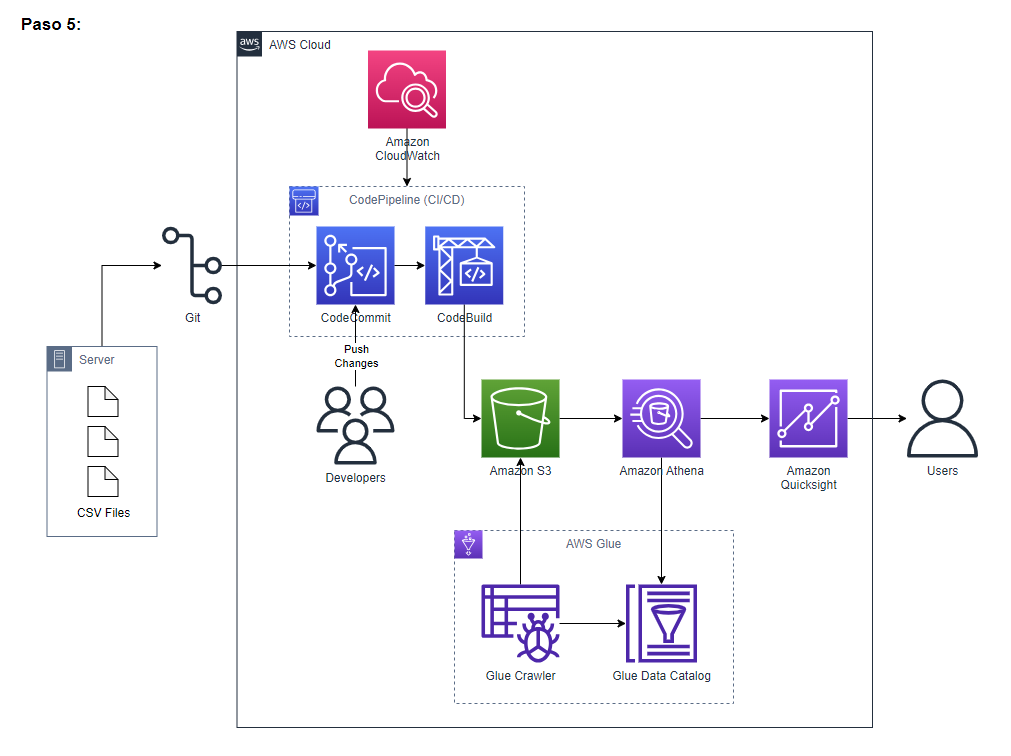